# Mapeando el Universo



## Aprendizaje Supervisado

### Clasificación del tipo morfológico de galaxias

  * Implementar los modelos random forest y redes neuronales para clasificar las galaxias en tipo Elípticas y Espirales e Irregulares
  
    + Utilizar al menos dos subconjuntos diferentes de variables (uno puede ser el mejor conjunto que les resultó del práctico anterior)
    + Realizar una búsqueda en grilla de los mejores parámetros de los modelos empleandos.
    + Comparar la performance con los modelos de perceptrón, regresión logística, vecinos más cercanos o el que hayan utilizado en el práctico anterior.
  
### Determinación del _redshift_ de las galaxias

  * Implementar los modelos de random forest, multi-layer perceptron y/o stochastic gradient descent para determinar el _redshift_ de las galaxias a partir de las propiedades fotométricas.
  
    + Utilizar al menos dos subconjuntos diferentes de variables (uno puede ser el mejor conjunto que les resultó del práctico anterior)
    + Determinar cuales son los parámetros de los algoritmos más importantes y realizar una búsqueda en grilla de los mejores parámetros de los modelos empleandos.
    + Elijan un métrica para evaluar el rendimiento de los métodos.
    
**NOTA**: No olviden realizar la división del dataset en un conjunto de entrenamiento y de test.
    
   

### Lectura de datos

Esto es una manera, pueden utilizar las que más les convenga

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import zipfile
import os.path

if not os.path.isfile('../data/DiploDatos_clean.csv'):
    path_to_zip_file = '../data/DiploDatos_clean.zip'
    directory_to_extract_to = '../data/'
    
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

filename = '../data/DiploDatos_clean.csv'
df = pd.read_csv(filename,index_col=0)
df

,z,subClass_AGN,subClass_AGN BROADLINE,subClass_BROADLINE,subClass_STARBURST,subClass_STARBURST BROADLINE,subClass_STARFORMING,subClass_STARFORMING BROADLINE,subClass_UNKNOWN,velDisp,...,modelColor_gr,modelColor_ri,modelColor_iz,petroColor_ug,petroColor_gr,petroColor_ri,petroColor_iz,spiral,elliptical,uncertain
specObjID,,,,,,,,,,,,,,,,,,,,,
957075158303008768,0.012095,0,0,0,1,0,0,0,0,60.39996,...,0.25431,0.09500,0.11706,0.79000,0.35837,0.15143,0.10247,0.0,0.0,1.0
957066087332079616,0.141718,0,0,0,0,0,0,0,1,217.80020,...,1.07714,0.45090,0.35530,2.11901,1.03352,0.43049,0.27852,0.0,0.0,1.0
957065537576265728,0.140137,0,0,0,0,0,0,0,1,138.90830,...,0.85273,0.41891,0.31316,1.07275,0.76730,0.36148,0.22301,1.0,0.0,0.0
957066911965800448,0.066672,0,0,0,0,0,0,0,1,241.28300,...,0.92406,0.42804,0.32709,1.90482,0.94006,0.41266,0.26840,0.0,1.0,0.0
693629150375733248,0.229718,0,0,0,0,0,0,0,1,198.84190,...,1.35756,0.48971,0.40055,2.99483,1.33661,0.49060,0.37582,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957077632204171264,0.150921,0,0,0,0,0,0,0,1,181.48450,...,1.03221,0.44277,0.30476,1.22845,0.93079,0.40980,0.05350,0.0,0.0,1.0
957077357326264320,0.084226,0,0,0,0,0,1,0,0,43.81417,...,0.67597,0.38023,0.24776,1.51657,0.61436,0.38013,0.17309,1.0,0.0,0.0
957066637087893504,0.141610,0,0,0,0,0,0,0,1,194.91520,...,1.09985,0.45063,0.33057,2.28958,0.96166,0.41758,0.25075,1.0,0.0,0.0


## Información de dataset

In [5]:
df['morphology'] = np.where(df.spiral == 1, 'spiral', 'Non classified')
df['morphology'] = np.where(df.elliptical == 1, 'elliptical', df['morphology'])
df['morphology'] = np.where(df.uncertain == 1, 'uncertain', df['morphology'])
# df.morphology.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531180 entries, 957075158303008768 to 957064987820451840
Data columns (total 84 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   z                               531180 non-null  float64
 1   subClass_AGN                    531180 non-null  int64  
 2   subClass_AGN BROADLINE          531180 non-null  int64  
 3   subClass_BROADLINE              531180 non-null  int64  
 4   subClass_STARBURST              531180 non-null  int64  
 5   subClass_STARBURST BROADLINE    531180 non-null  int64  
 6   subClass_STARFORMING            531180 non-null  int64  
 7   subClass_STARFORMING BROADLINE  531180 non-null  int64  
 8   subClass_UNKNOWN                531180 non-null  int64  
 9   velDisp                         531180 non-null  float64
 10  ra                              531180 non-null  float64
 11  dec                             531180 non-null  

In [7]:
"""reducing.py
Author: Kirgsn, 2018

Use like this:
>>> import reducing
>>> df = reducing.Reducer().reduce(df)
"""
import numpy as np
import pandas as pd
import time
import gc
from joblib import Parallel, delayed
from fastprogress import master_bar, progress_bar

__all__ = ['Reducer']

def measure_time_mem(func):
    def wrapped_reduce(self, df, *args, **kwargs):
        # pre
        mem_usage_orig = df.memory_usage().sum() / self.memory_scale_factor
        start_time = time.time()
        # exec
        ret = func(self, df, *args, **kwargs)
        # post
        mem_usage_new = ret.memory_usage().sum() / self.memory_scale_factor
        end_time = time.time()
        print(f'reduced df from {mem_usage_orig:.4f} MB '
              f'to {mem_usage_new:.4f} MB '
              f'in {(end_time - start_time):.2f} seconds')
        gc.collect()
        return ret
    return wrapped_reduce


class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe into, in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None, use_categoricals=True, n_jobs=-1):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        :param use_categoricals: Whether the new pandas dtype "Categoricals"
                shall be used
        :param n_jobs: Parallelization rate
        """

        self.conversion_table = \
            conv_table or {'int': [np.int8, np.int16, np.int32, np.int64],
                           'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                           'float': [np.float32, ]}
        self.null_int = {   np.int8:  pd.Int8Dtype,
                            np.int16: pd.Int16Dtype,
                            np.int32: pd.Int32Dtype,
                            np.int64: pd.Int64Dtype,
                            np.uint8: pd.UInt8Dtype,
                            np.uint16:pd.UInt16Dtype,
                            np.uint32:pd.UInt32Dtype,
                            np.uint64:pd.UInt64Dtype}
        
        self.use_categoricals = use_categoricals
        self.n_jobs = n_jobs

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    @measure_time_mem
    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=self.n_jobs, max_nbytes=None)(progress_bar(list(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)))

        del df
        gc.collect()
        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):
        try:
            isnull = False
            # skip NaNs
            if s.isnull().any():
                isnull = True
            # detect kind of type
            coltype = s.dtype
            if np.issubdtype(coltype, np.integer):
                conv_key = 'int' if s.min() < 0 else 'uint'
            elif np.issubdtype(coltype, np.floating):
                conv_key = 'float'
                asint = s.fillna(0).astype(np.int64)
                result = (s - asint)
                result = np.abs(result.sum())
                if result < 0.01:
                    conv_key = 'int' if s.min() < 0 else 'uint'
            else:
                if isinstance(coltype, object) and self.use_categoricals:
                    # check for all-strings series
                    if s.apply(lambda x: isinstance(x, str)).all():
                        if verbose: print(f'convert {colname} to categorical')
                        return s.astype('category')
                if verbose: print(f'{colname} is {coltype} - Skip..')
                return s
            # find right candidate
            for cand, cand_info in self._type_candidates(conv_key):
                if s.max() <= cand_info.max and s.min() >= cand_info.min:
                    if verbose: print(f'convert {colname} to {cand}')
                    if isnull:
                        return s.astype(self.null_int[cand]())
                    else:
                        return s.astype(cand)

            # reaching this code is bad. Probably there are inf, or other high numbs
            print(f"WARNING: {colname} doesn't fit the grid with \nmax: {s.max()} "
                f"and \nmin: {s.min()}")
            print('Dropping it..')
        except Exception as ex:
            print(f'Exception for {colname}: {ex}')
            return s

Reducimos los tipos de datos de los atributos para un mejor manejo de memoria y cálculo

In [8]:
df = Reducer().reduce(df)
df.info()

reduced df from 344.4695 MB to 156.0244 MB in 14.20 seconds
<class 'pandas.core.frame.DataFrame'>
Int64Index: 531180 entries, 957075158303008768 to 957064987820451840
Data columns (total 84 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   z                               531180 non-null  float32 
 1   subClass_AGN                    531180 non-null  uint8   
 2   subClass_AGN BROADLINE          531180 non-null  uint8   
 3   subClass_BROADLINE              531180 non-null  uint8   
 4   subClass_STARBURST              531180 non-null  uint8   
 5   subClass_STARBURST BROADLINE    531180 non-null  uint8   
 6   subClass_STARFORMING            531180 non-null  uint8   
 7   subClass_STARFORMING BROADLINE  531180 non-null  uint8   
 8   subClass_UNKNOWN                531180 non-null  uint8   
 9   velDisp                         531180 non-null  float32 
 10  ra                              531180 

## Balanceo de dataset

uncertain     347042
spiral        141869
elliptical     42269
Name: morphology, dtype: int64


<AxesSubplot:>

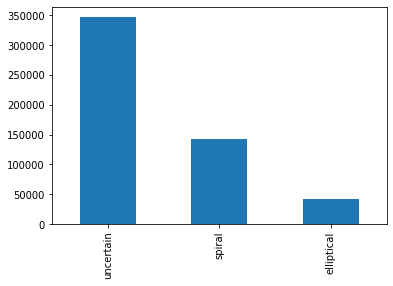

In [9]:
print(df.morphology.value_counts())
df.morphology.value_counts().plot.bar()

Muy desbalanceado entre las 3 clases. Procedemos a llevarlas a un punto medio entre las 3 
"(uncertain - elliptical)/2 = 152386 ≅ spiral"

In [10]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.morphology == 'uncertain']
df_minority = df[df.morphology == 'elliptical']
 
# Downsample majority class
df_majority = resample(df_majority, 
             replace=False,    # sample without replacement
             n_samples=round(len(df[df.morphology == 'spiral'])),# to match minority class
             random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority, df_minority])
 
# Display new class counts
df_downsampled.morphology.value_counts()

uncertain     141869
elliptical     42269
spiral             0
Name: morphology, dtype: int64

uncertain     141869
spiral        141869
elliptical    141869
Name: morphology, dtype: int64


<AxesSubplot:>

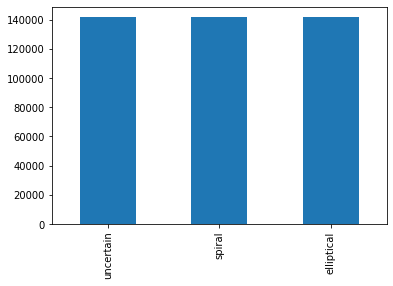

In [11]:

# Upsample minority class
df_minority = resample(df_minority, 
             replace=True,                           # sample with replacement
             n_samples=round(len(df[df.morphology == 'spiral'])),    # to match majority class
             random_state=123)                       # reproducible results
 
# Combine majority class with upsampled minority class
df_target = pd.concat([df_majority, df_minority, df[df.morphology == 'spiral']])
 
# Display new class counts
print(df_target.morphology.value_counts())
df_target.morphology.value_counts().plot.bar()

## Entrenamiento

#### Separación de subconjuntos

In [26]:
modelMag_deVRad = [col for col in df if col.startswith('model')]
modelMag_deVRad = modelMag_deVRad + [col for col in df if col.startswith('deVRad_')]

modelMag_expRad = [col for col in df if col.startswith('model')]
modelMag_expRad = modelMag_expRad + [col for col in df if col.startswith('expRad_')]

petro = [col for col in df if col.startswith('petro')]

#### Entrenamiento

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [36]:
def model_train_test(model, X, y): 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

    ss= StandardScaler()
    ss.fit(X)
    X_train= ss.transform(X_train)
    X_test= ss.transform(X_test)

    # Entrenar
    model.fit(X_train, y_train)

    return model, X_train, y_train, X_test, y_test

Entrenamos cada modelo con cada subconjunto para elegir la mejor combinación entre ambos

********************************************************************
RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.7746411033575339


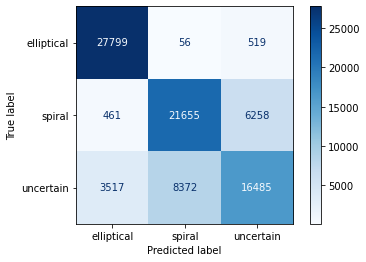

RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.785120180446888


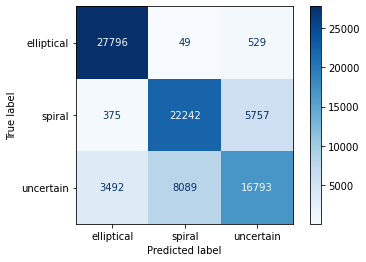

RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=0)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.7662648903926129


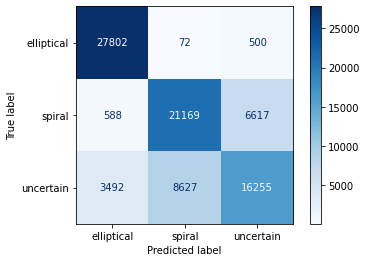

********************************************************************
MLPClassifier(hidden_layer_sizes=83, max_iter=20, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.720037123187895


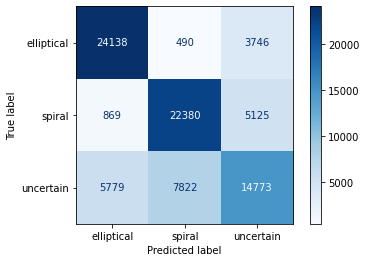

MLPClassifier(hidden_layer_sizes=83, max_iter=20, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.7276379784309579


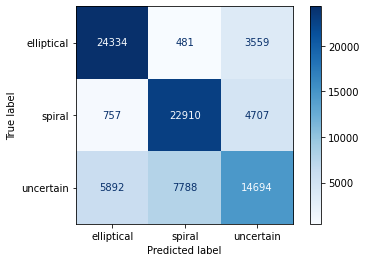

MLPClassifier(hidden_layer_sizes=83, max_iter=20, random_state=0)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.7186626254082376


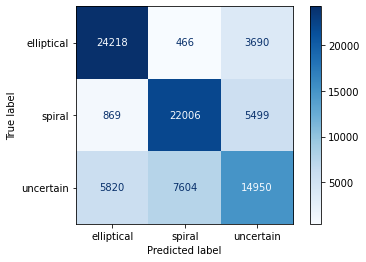

********************************************************************
SGDClassifier(max_iter=100, n_jobs=-1, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.6939921524400272


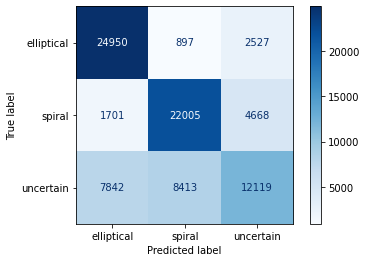

SGDClassifier(max_iter=100, n_jobs=-1, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.7042480204882404


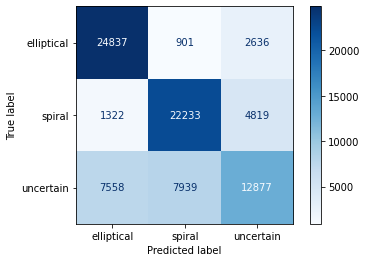

SGDClassifier(max_iter=100, n_jobs=-1, random_state=0)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.6777331359695495


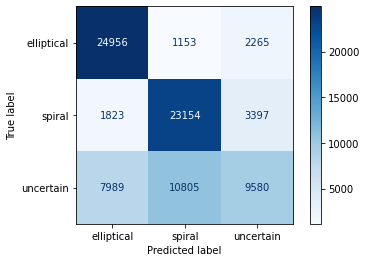

********************************************************************
Perceptron(n_jobs=-1)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.6378609525152135


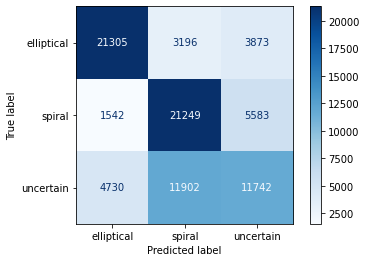

Perceptron(n_jobs=-1)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.6626254082375884


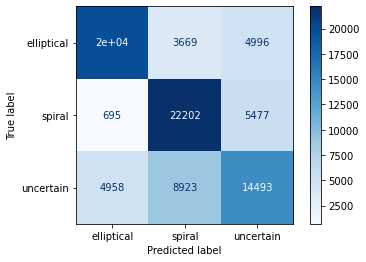

Perceptron(n_jobs=-1)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.6360517844975447


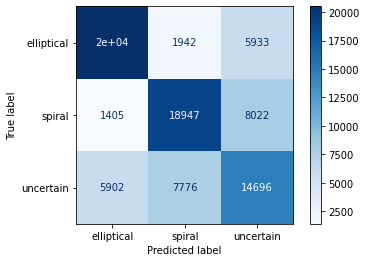

********************************************************************
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=35, n_jobs=-1, num_parallel_tree=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.7195084701957191


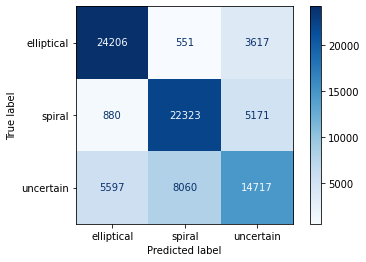

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=35, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.7320786635652358


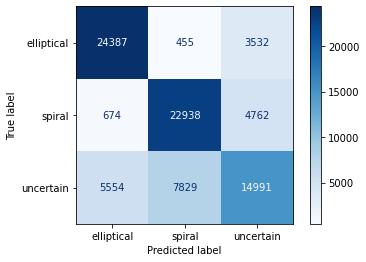

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=35, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.71302366

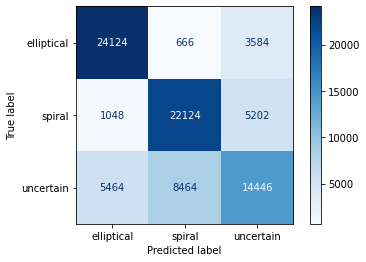

********************************************************************
LogisticRegression(n_jobs=-1, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.692030262446841


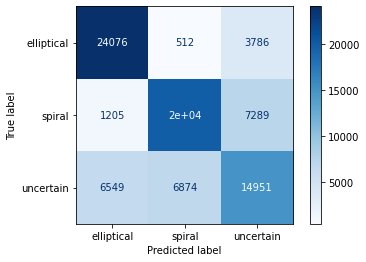

LogisticRegression(n_jobs=-1, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.70403655929137


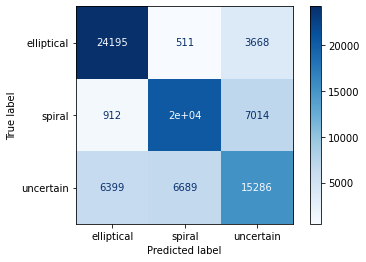

LogisticRegression(n_jobs=-1, random_state=0)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.6865910105495642


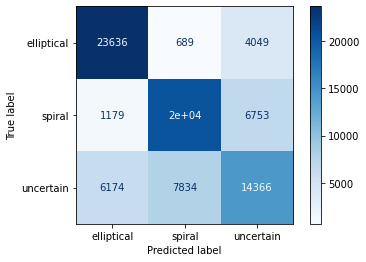

********************************************************************
LinearSVC(max_iter=50, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'deVRad_u', 'deVRad_g', 'deVRad_r', 'deVRad_i', 'deVRad_z'] 

Score:  0.6759592114846925


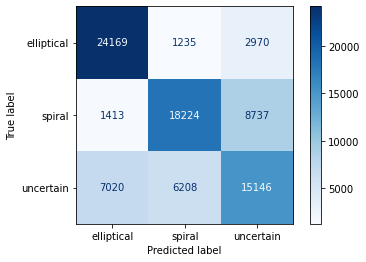

LinearSVC(max_iter=50, random_state=0)  -  ['modelMag_u', 'modelMag_g', 'modelMag_r', 'modelMag_i', 'modelMag_z', 'modelColor_ug', 'modelColor_gr', 'modelColor_ri', 'modelColor_iz', 'expRad_u', 'expRad_g', 'expRad_r', 'expRad_i', 'expRad_z'] 

Score:  0.7024623481591128


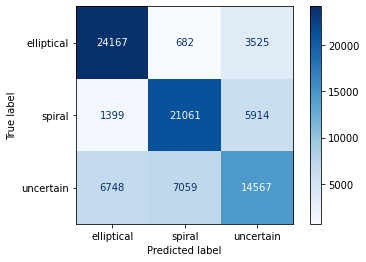

LinearSVC(max_iter=50, random_state=0)  -  ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_i', 'petroR90_z', 'petroColor_ug', 'petroColor_gr', 'petroColor_ri', 'petroColor_iz'] 

Score:  0.6649162378703508


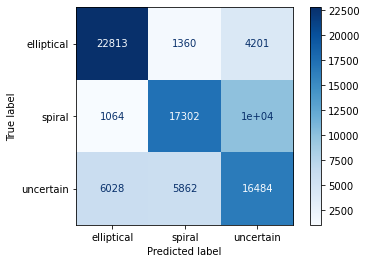

In [21]:
groups= [modelMag_deVRad, modelMag_expRad, petro]
# y = pd.get_dummies(df[['morphology']])
# y = OneHotEncoder(sparse= False).fit_transform(df[['morphology']])
y = df_target[['morphology']]
models = [RandomForestClassifier(n_jobs=-1, n_estimators=15, random_state= 0), 
          MLPClassifier(random_state= 0, max_iter= 20, hidden_layer_sizes=(83)), 
          SGDClassifier(random_state=0, n_jobs= -1, max_iter= 100), Perceptron(random_state=0, n_jobs= -1),
          XGBClassifier(n_jobs=-1, random_state= 0, n_estimators= 35), 
          LogisticRegression(n_jobs= -1, random_state=0,), LinearSVC(random_state= 0, max_iter=50)]

for model in models:
    print('********************************************************************')
    for group in groups:

        print(model, ' - ', group , '\n')
        X = df_target[group]
        model, X_train, y_train, X_test, y_test= model_train_test(model, X, y)
        print('Score: ', model.score(X_test,y_test))
        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues )
        plt.show() 


## Búsqueda de los mejores parámetros

In [38]:
from sklearn.model_selection import GridSearchCV


y = df_target[['morphology']]
X = df_target[modelMag_expRad]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, stratify= y)

ss= StandardScaler()
ss.fit(X)
X_train= ss.transform(X_train)
X_test= ss.transform(X_test)

param_grid_rfc = { 
    'n_estimators': [5, 15, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,50,100,None],
    'criterion' :['gini', 'entropy']
}

param_grid_mlpc = {
    'hidden_layer_sizes': [(10,30,10),(83, 83), (83,), (40,40)],
    'activation': ['tanh', 'relu', 'logistic', 'identity'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05, 1],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'max_iter': [10, 20, 100]
}


mlpc_gscv = GridSearchCV(MLPClassifier(), param_grid=param_grid_mlpc, cv= 3, n_jobs= -1 )
mlpc_gscv.fit(X_train, y_train)

rfc_gscv = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_rfc, cv= 3, n_jobs= -1 )
rfc_gscv.fit(X_train, y_train)


In [29]:
print(mlpc_gscv.best_params_, mlpc_gscv.best_estimator_, mlpc_gscv.best_score_)
print(rfc_gscv.best_params_, rfc_gscv.best_estimator_, rfc_gscv.best_score_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (83, 83), 'learning_rate': 'adaptive', 'max_iter': 100, 'solver': 'adam'} MLPClassifier(hidden_layer_sizes=(83, 83), learning_rate='adaptive',
              max_iter=100) 0.7316151959704539
{'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'n_estimators': 200} RandomForestClassifier(max_depth=50, max_features='log2', n_estimators=200) 0.7834970703555223


En el caso de RandomForestClassifier obtuvimos mejores resutlados con los parámetros seteados en un principio

In [28]:
import joblib
joblib.dump(rfc_gscv, "randomforestCV.pkl")
joblib.dump(mlpc_gscv, "mlpclasiffierCV.pkl")

['mlpclasiffierCV.pkl']

Encontramos otro subconjuto de entrenamiento que aumenta la exactitud del modelo uniendo expRad con petro

RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=0)
Score:  0.8022485373933883


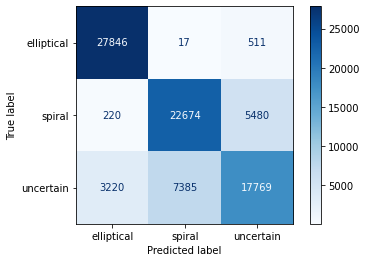

In [47]:
model= RandomForestClassifier(n_jobs=-1, n_estimators=15, random_state= 0)

modelMag_expRad.extend(petro)

print(model)
X = df_target[modelMag_expRad]
y= df_target[['morphology']]
model, X_train, y_train, X_test, y_test= model_train_test(model, X, y)
print('Score: ', model.score(X_test,y_test))
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues )
plt.show() 


Notamos que "uncertain" no tiene un patrn definido y por ende agrega mucho ruido. Al sacarlo la exactitud del modelo aumenta considerablemente

RandomForestClassifier(n_estimators=15, n_jobs=-1, random_state=0)
Score:  0.9834002960456756


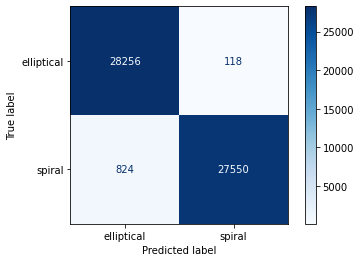

In [30]:
model= RandomForestClassifier(n_jobs=-1, random_state= 0, n_estimators= 15)
print(model)
modelMag_expRad.extend(petro)

df_target= df_target[df_target['morphology'] != 'uncertain']
X = df_target[modelMag_expRad]
y= df_target[['morphology']]

model, X_train, y_train, X_test, y_test= model_train_test(model, X, y)
print('Score: ', model.score(X_test,y_test))
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues )
plt.show() 